In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('training_dataset.csv')
num_rows = df.shape[0]
num_rows

22916

In [5]:
# Target and features
y = df["berlangganan_deposito"]
X = df.drop(columns=["berlangganan_deposito", "customer_number"])

In [6]:
categorical_columns = [
    'pekerjaan', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya',
    'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir',
    'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya'
]

numerical_features = [
    'usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya',
    'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan',
    'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen',
    'suku_bunga_euribor_3bln', 'jumlah_pekerja'
]

In [7]:
for col in categorical_columns:
    X[col] = X[col].astype(str)

In [8]:
# Split data before preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [11]:
# XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [12]:
# Full pipeline with SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb_clf)
])

In [13]:
# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0,2, 0.3],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]
}

In [14]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# Grid Search
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [16]:
# Fit model
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


c:\Users\Geovanka\Documents\GitHub\DataQuest_Deposito\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:37:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['usia',
                                                                          'jumlah_kontak_kampanye_ini',
                                                                          'hari_sejak_kontak_sebelumnya',
                                                                          'jumlah_kontak_sebelumnya',
                                                                          'tingkat_v...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.6, 0.8, 1.0],
                         'classifier__learning_rate': [0.01, 0.05, 0.1, 0, 2,
                                                       0.3],
                         'classifier__max_depth': [3, 5, 7, 9],
                         'classifier__n_estimators': [100, 200, 300, 400, 500],
                         'classifier__subsample': [0.6, 0.8, 1.0]},
             scoring='neg_log_loss', verbose=1)

In [17]:
# Best params
print("Best parameters:", grid.best_params_)
print("Best validation log loss:", -grid.best_score_)

Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 400, 'classifier__subsample': 0.8}
Best validation log loss: 0.2856163907194158


In [18]:
# Evaluate on test set
y_pred_proba = grid.predict_proba(X_test)
print("Test set log loss:", log_loss(y_test, y_pred_proba))

Test set log loss: 0.28277759037882416


In [19]:
# Evaluate on test set
y_pred_proba = grid.predict_proba(X_test)
y_pred_class = grid.predict(X_test)

print("Test set log loss:", log_loss(y_test, y_pred_proba))
print("Test set accuracy:", accuracy_score(y_test, y_pred_class))

Test set log loss: 0.28277759037882416
Test set accuracy: 0.8946335078534031


In [20]:
# Predicted probabilities for the positive class (1)
y_pred_proba = grid.predict_proba(X_test)[:, 1]  # get probability for class 1

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred_proba)

print("Test set AUC score:", auc)

Test set AUC score: 0.7817555698165124


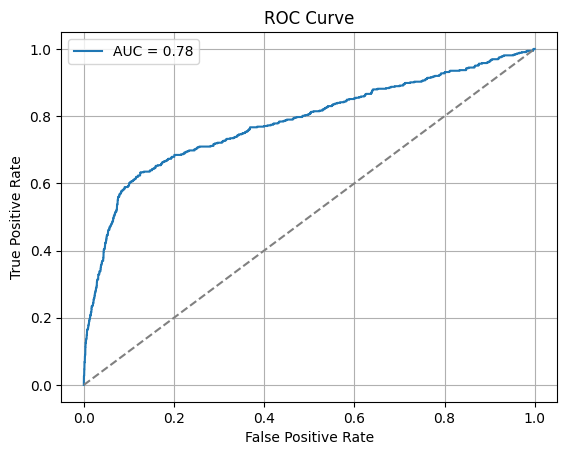

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [23]:
# Load your new dataset
new_data = pd.read_csv('validation_set.csv')

In [24]:
# Predict class
new_preds = grid.predict(new_data)

# Predict probabilities (optional, for e.g., log loss or AUC)
new_pred_probs = grid.predict_proba(new_data)[:, 1]  # probability of class 1

# Add predictions as new columns
new_data['predicted_class'] = new_preds
new_data['predicted_proba'] = new_pred_probs

# Save to new CSV
new_data.to_csv('new_data_with_predictions.csv', index=False)

In [25]:
data_w_pred = pd.read_csv('new_data_with_predictions.csv')
data_w_pred

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,predicted_class,predicted_proba
0,445420,35,penyedia jasa,menikah,SMA,no,yes,yes,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,Jawa,0,0.058757
1,585604,52,teknisi,lajang,Diploma,unknown,no,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,Papua,0,0.029824
2,888824,37,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Bali,0,0.035956
3,816820,51,pengangguran,menikah,Diploma,no,no,no,telephone,may,tue,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,Sumatera,0,0.030696
4,542716,45,teknisi,cerai,SMA,no,yes,no,cellular,may,thu,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,Sumatera,0,0.054551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,782072,51,pekerja kasar,menikah,Tidak Tamat SD,no,yes,no,telephone,jun,tue,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,Kalimantan,0,0.087718
5725,116371,30,pekerja kasar,menikah,SMP,no,yes,yes,telephone,may,fri,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,Sulawesi,0,0.057954
5726,773759,45,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,NTB,0,0.029474
5727,612330,60,teknisi,menikah,Diploma,unknown,no,no,telephone,jul,tue,15,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,Papua,0,0.011263
